# 基于TensorFlow实现Skip-Gram模型   

## Word2Vec之Skip-Gram模型

下面代码将用TensorFlow实现Word2Vec中的Skip-Gram模型。

关于Skip-Gram模型请参考[深入浅出Word2Vec原理解析](https://mp.weixin.qq.com/s/zDneR1BU6xvt8cndEF4_Xw)

##  1 导入包

In [1]:
import time
import numpy as np
import tensorflow as tf
import random
from collections import Counter

## 2 加载数据

数据集使用的是来自Matt Mahoney的维基百科文章，数据集已经被清洗过，去除了特殊符号等，并不是全量数据，只是部分数据，所以实际上最后训练出的结果很一般（语料不够）。

如果想获取更全的语料数据，可以访问以下网站，这是gensim中Word2Vec提供的语料：

- 来自Matt Mahoney预处理后的[文本子集](http://mattmahoney.net/dc/enwik9.zip)，里面包含了10亿个字符。
- 与第一条一样的经过预处理的[文本数据](http://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2)，但是包含了30个亿的字符。
- 多种语言的[训练文本](http://www.statmt.org/wmt11/translation-task.html#download)。
- [UMBC webbase corpus](http://ebiquity.umbc.edu/redirect/to/resource/id/351/UMBC-webbase-corpus)

In [3]:
with open('./text8.txt') as f:
    text = f.read()

## 3 数据预处理

数据预处理过程主要包括：

- 替换文本中特殊符号并去除低频词
- 对文本分词
- 构建语料
- 单词映射表

In [4]:
# 定义函数来完成数据的预处理
def preprocess(text, freq=5):
    '''
    对文本进行预处理
    
    参数
    ---
    text: 文本数据
    freq: 词频阈值
    '''
    # 对文本中的符号进行替换
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # 删除低频词，减少噪音影响
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

In [5]:
# 清洗文本并分词
words = preprocess(text)
print(words[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [6]:
# 构建映射表
vocab = set(words)
vocab_to_int = {w: c for c, w in enumerate(vocab)}
int_to_vocab = {c: w for c, w in enumerate(vocab)}

In [7]:
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(set(words))))

total words: 16680599
unique words: 63641


In [8]:
# 对原文本进行vocab到int的转换
int_words = [vocab_to_int[w] for w in words]

## 4 采样
对停用词进行采样，例如“the”， “of”以及“for”这类单词进行剔除。剔除这些单词以后能够加快我们的训练过程，同时减少训练过程中的噪音。

我们采用以下公式:$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$ t $是一个阈值参数，一般为1e-3至1e-5。   
$f(w_i)$ 是单词 $w_i$ 在整个数据集中的出现频次。   
$P(w_i)$ 是单词被删除的概率。   

这个公式和论文中描述的那个公式有一些不同

In [9]:
t = 1e-5 # t值
threshold = 0.8 # 剔除概率阈值

# 统计单词出现频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
# 计算单词频率
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
# 计算被删除的概率
prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}
# 对单词进行采样
train_words = [w for w in int_words if prob_drop[w] < threshold]

In [10]:
len(train_words)

6925252

In [11]:
# 从上面数据可以看到，我们本身有1670万的文本，经过采样后剩下693万。

## 5 构造batch

Skip-Gram模型是通过输入词来预测上下文。因此我们要构造我们的训练样本，具体思想请参考[深入浅出Word2Vec原理解析](https://mp.weixin.qq.com/s/zDneR1BU6xvt8cndEF4_Xw)，这里不再重复。

对于一个给定词，离它越近的词可能与它越相关，离它越远的词越不相关，这里我们设置窗口大小为5，对于每个训练单词，我们还会在[1:5]之间随机生成一个整数R，用R作为我们最终选择output word的窗口大小。这里之所以多加了一步随机数的窗口重新选择步骤，是为了能够让模型更聚焦于当前input word的邻近词。

In [13]:
def get_targets(words, idx, window_size=5):
    '''
    获得input word的上下文单词列表
    
    参数
    ---
    words: 单词列表
    idx: input word的索引号
    window_size: 窗口大小
    '''
    target_window = np.random.randint(1, window_size+1)
    # 这里要考虑input word前面单词不够的情况
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    # output words(即窗口中的上下文单词)
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)

In [14]:
def get_batches(words, batch_size, window_size=5):
    '''
    构造一个获取batch的生成器
    '''
    n_batches = len(words) // batch_size
    
    # 仅取full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # 由于一个input word会对应多个output word，因此需要长度统一
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y

# 6 构建网络

该部分主要包括：

- 输入层
- Embedding
- Negative Sampling

### 输入

In [15]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')

### Embedding

嵌入矩阵的矩阵形状为 $ vocab\_size\times hidden\_units\_size$

TensorFlow中的tf.nn.embedding_lookup函数可以实现lookup的计算方式

In [17]:
vocab_size = len(int_to_vocab)
embedding_size = 200 # 嵌入维度

In [18]:
with train_graph.as_default():
    # 嵌入层权重矩阵
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    # 实现lookup
    embed = tf.nn.embedding_lookup(embedding, inputs)

### Negative Sampling

负采样主要是为了解决梯度下降计算速度慢的问题，详情同样参考我的文章[深入浅出Word2Vec原理解析](https://mp.weixin.qq.com/s/zDneR1BU6xvt8cndEF4_Xw)。

TensorFlow中的tf.nn.sampled_softmax_loss会在softmax层上进行采样计算损失，计算出的loss要比full softmax loss低。

In [19]:
n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # 计算negative sampling下的损失
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

### 验证

为了更加直观的看到我们训练的结果，我们将查看训练出的相近语义的词。

In [20]:
with train_graph.as_default():
    # 随机挑选一些单词
    valid_size = 16 
    valid_window = 100
    # 从不同位置各选8个单词
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    
    valid_size = len(valid_examples)
    # 验证单词集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 计算每个词向量的模并进行单位化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    # 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # 计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [22]:
epochs = 10 # 迭代轮数
batch_size = 1000 # batch大小
window_size = 10 # 窗口大小

with train_graph.as_default():
    saver = tf.train.Saver() # 文件存储

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        # 
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            # 计算相似的词
            if iteration % 1000 == 0:
                # 计算similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # 取最相似单词的前8个
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 3.7086 0.0728 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 3.6427 0.0793 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 3.6621 0.0753 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 3.5863 0.0759 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 3.5710 0.0773 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 3.5181 0.0736 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 3.4591 0.0716 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 3.4796 0.0718 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 3.3483 0.0715 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 3.3337 0.0796 sec/batch
Nearest to [clearances]: sto, loco, lucretius, villainous, beatnik, cortland, hotbed, brag,
Nearest to [visualizing]: pineapple, kh, ppg, invariably, estados, legal, koopa, nuur,
Nearest to [girl]: lamont, dobson, callers, fringed, protectorates, perkin, excited, dislodge,
Nearest to [omri]: lineag

Epoch 1/10 Iteration: 4100 Avg. Training loss: 2.5613 0.0732 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 2.6351 0.0713 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 2.5403 0.0814 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 2.5419 0.0724 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 2.5434 0.0719 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 2.5046 0.0711 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 2.6018 0.0725 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 2.5892 0.0709 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 2.4072 0.0711 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 2.5200 0.0711 sec/batch
Nearest to [clearances]: loco, lucretius, sto, principles, cortland, villainous, beggar, hotbed,
Nearest to [visualizing]: kh, invariably, ppg, pineapple, legal, earthy, fascism, flores,
Nearest to [girl]: fringed, dobson, lamont, anderson, disorganised, protectorates, dislodge, gramsci,
N

Epoch 2/10 Iteration: 8100 Avg. Training loss: 2.3753 0.0729 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 2.3039 0.0712 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 2.4272 0.0712 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 2.3331 0.0791 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 2.2265 0.0744 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 2.1108 0.0710 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 2.2999 0.0718 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 2.2333 0.0705 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 2.2479 0.0697 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 2.4765 0.0705 sec/batch
Nearest to [clearances]: sto, loco, lucretius, principles, dps, villainous, beatnik, cortland,
Nearest to [visualizing]: pineapple, invariably, kh, estados, ppg, refreshable, koopa, consequentialism,
Nearest to [girl]: fringed, dobson, lamont, anderson, gramsci, disorganised, erotic, telli

Epoch 2/10 Iteration: 12100 Avg. Training loss: 2.1303 0.0733 sec/batch
Epoch 2/10 Iteration: 12200 Avg. Training loss: 2.3100 0.0724 sec/batch
Epoch 2/10 Iteration: 12300 Avg. Training loss: 2.2397 0.0719 sec/batch
Epoch 2/10 Iteration: 12400 Avg. Training loss: 2.3119 0.0727 sec/batch
Epoch 2/10 Iteration: 12500 Avg. Training loss: 2.3515 0.0748 sec/batch
Epoch 2/10 Iteration: 12600 Avg. Training loss: 2.3328 0.0784 sec/batch
Epoch 2/10 Iteration: 12700 Avg. Training loss: 2.2474 0.0717 sec/batch
Epoch 2/10 Iteration: 12800 Avg. Training loss: 2.0895 0.0716 sec/batch
Epoch 2/10 Iteration: 12900 Avg. Training loss: 2.2760 0.0715 sec/batch
Epoch 2/10 Iteration: 13000 Avg. Training loss: 2.2306 0.0713 sec/batch
Nearest to [clearances]: sto, lucretius, loco, principles, beatnik, dps, cortland, al,
Nearest to [visualizing]: pineapple, invariably, kh, koopa, ppg, wgbh, estados, nuur,
Nearest to [girl]: fringed, dobson, lamont, edwina, excited, kraftwerk, disorganised, tellings,
Nearest to 

Epoch 3/10 Iteration: 16100 Avg. Training loss: 2.1502 0.0734 sec/batch
Epoch 3/10 Iteration: 16200 Avg. Training loss: 2.0792 0.0711 sec/batch
Epoch 3/10 Iteration: 16300 Avg. Training loss: 2.2213 0.0710 sec/batch
Epoch 3/10 Iteration: 16400 Avg. Training loss: 2.1505 0.0704 sec/batch
Epoch 3/10 Iteration: 16500 Avg. Training loss: 2.0799 0.0719 sec/batch
Epoch 3/10 Iteration: 16600 Avg. Training loss: 2.1933 0.0718 sec/batch
Epoch 3/10 Iteration: 16700 Avg. Training loss: 2.1664 0.0815 sec/batch
Epoch 3/10 Iteration: 16800 Avg. Training loss: 2.1751 0.0711 sec/batch
Epoch 3/10 Iteration: 16900 Avg. Training loss: 1.9616 0.0711 sec/batch
Epoch 3/10 Iteration: 17000 Avg. Training loss: 2.0908 0.0712 sec/batch
Nearest to [clearances]: sto, lucretius, loco, dps, beatnik, principles, hotbed, cortland,
Nearest to [visualizing]: pineapple, koopa, kh, ppg, estados, wgbh, invariably, emeralds,
Nearest to [girl]: fringed, dobson, lamont, excited, kraftwerk, anderson, edwina, garson,
Nearest t

Epoch 3/10 Iteration: 20100 Avg. Training loss: 1.9758 0.0733 sec/batch
Epoch 3/10 Iteration: 20200 Avg. Training loss: 1.9268 0.0712 sec/batch
Epoch 3/10 Iteration: 20300 Avg. Training loss: 2.1384 0.0715 sec/batch
Epoch 3/10 Iteration: 20400 Avg. Training loss: 2.0352 0.0717 sec/batch
Epoch 3/10 Iteration: 20500 Avg. Training loss: 2.1557 0.0711 sec/batch
Epoch 3/10 Iteration: 20600 Avg. Training loss: 2.1482 0.0713 sec/batch
Epoch 3/10 Iteration: 20700 Avg. Training loss: 2.2200 0.0720 sec/batch
Epoch 4/10 Iteration: 20800 Avg. Training loss: 2.2199 0.0190 sec/batch
Epoch 4/10 Iteration: 20900 Avg. Training loss: 2.0093 0.0710 sec/batch
Epoch 4/10 Iteration: 21000 Avg. Training loss: 2.1210 0.0717 sec/batch
Nearest to [clearances]: sto, lucretius, dps, loco, principles, beatnik, hotbed, beggar,
Nearest to [visualizing]: pineapple, kh, estados, maguey, koopa, ppg, wgbh, fascism,
Nearest to [girl]: fringed, dobson, lamont, excited, kraftwerk, garson, erotic, edwina,
Nearest to [omri]:

Epoch 4/10 Iteration: 24100 Avg. Training loss: 2.1626 0.0813 sec/batch
Epoch 4/10 Iteration: 24200 Avg. Training loss: 2.0797 0.0706 sec/batch
Epoch 4/10 Iteration: 24300 Avg. Training loss: 2.1177 0.0726 sec/batch
Epoch 4/10 Iteration: 24400 Avg. Training loss: 2.1436 0.0714 sec/batch
Epoch 4/10 Iteration: 24500 Avg. Training loss: 2.1505 0.0742 sec/batch
Epoch 4/10 Iteration: 24600 Avg. Training loss: 2.1118 0.0747 sec/batch
Epoch 4/10 Iteration: 24700 Avg. Training loss: 1.9177 0.0711 sec/batch
Epoch 4/10 Iteration: 24800 Avg. Training loss: 1.9154 0.0714 sec/batch
Epoch 4/10 Iteration: 24900 Avg. Training loss: 2.0776 0.0787 sec/batch
Epoch 4/10 Iteration: 25000 Avg. Training loss: 2.1515 0.0719 sec/batch
Nearest to [clearances]: sto, lucretius, loco, dps, principles, beggar, hotbed, hyperlink,
Nearest to [visualizing]: pineapple, refreshable, fascism, koopa, deoxyribose, ppg, maguey, earthy,
Nearest to [girl]: fringed, dobson, excited, lamont, garson, kraftwerk, anderson, alight,

Epoch 5/10 Iteration: 28100 Avg. Training loss: 2.1000 0.0734 sec/batch
Epoch 5/10 Iteration: 28200 Avg. Training loss: 2.2953 0.0805 sec/batch
Epoch 5/10 Iteration: 28300 Avg. Training loss: 2.0041 0.0722 sec/batch
Epoch 5/10 Iteration: 28400 Avg. Training loss: 2.1013 0.0722 sec/batch
Epoch 5/10 Iteration: 28500 Avg. Training loss: 2.1481 0.0721 sec/batch
Epoch 5/10 Iteration: 28600 Avg. Training loss: 2.0726 0.0717 sec/batch
Epoch 5/10 Iteration: 28700 Avg. Training loss: 1.9088 0.0714 sec/batch
Epoch 5/10 Iteration: 28800 Avg. Training loss: 2.0465 0.0707 sec/batch
Epoch 5/10 Iteration: 28900 Avg. Training loss: 1.9780 0.0714 sec/batch
Epoch 5/10 Iteration: 29000 Avg. Training loss: 2.0404 0.0789 sec/batch
Nearest to [clearances]: sto, lucretius, loco, principles, dps, beggar, hyperlink, hotbed,
Nearest to [visualizing]: pineapple, ppg, fascism, maguey, koopa, refreshable, wgbh, earthy,
Nearest to [girl]: fringed, excited, dobson, garson, anderson, lamont, kraftwerk, alight,
Neares

Epoch 5/10 Iteration: 32100 Avg. Training loss: 1.9215 0.0738 sec/batch
Epoch 5/10 Iteration: 32200 Avg. Training loss: 2.0904 0.0703 sec/batch
Epoch 5/10 Iteration: 32300 Avg. Training loss: 2.0078 0.0793 sec/batch
Epoch 5/10 Iteration: 32400 Avg. Training loss: 2.1743 0.0730 sec/batch
Epoch 5/10 Iteration: 32500 Avg. Training loss: 1.9949 0.0712 sec/batch
Epoch 5/10 Iteration: 32600 Avg. Training loss: 1.9738 0.0710 sec/batch
Epoch 5/10 Iteration: 32700 Avg. Training loss: 1.9077 0.0712 sec/batch
Epoch 5/10 Iteration: 32800 Avg. Training loss: 2.0976 0.0719 sec/batch
Epoch 5/10 Iteration: 32900 Avg. Training loss: 2.0582 0.0720 sec/batch
Epoch 5/10 Iteration: 33000 Avg. Training loss: 1.9956 0.0733 sec/batch
Nearest to [clearances]: sto, loco, dps, lucretius, principles, beggar, hyperlink, beatnik,
Nearest to [visualizing]: koopa, pineapple, maguey, refreshable, fascism, ppg, ariary, kh,
Nearest to [girl]: fringed, excited, dobson, kraftwerk, anderson, thickening, alight, starlost,
N

Epoch 6/10 Iteration: 36100 Avg. Training loss: 2.1208 0.0732 sec/batch
Epoch 6/10 Iteration: 36200 Avg. Training loss: 1.9586 0.0711 sec/batch
Epoch 6/10 Iteration: 36300 Avg. Training loss: 1.9357 0.0705 sec/batch
Epoch 6/10 Iteration: 36400 Avg. Training loss: 1.9932 0.0780 sec/batch
Epoch 6/10 Iteration: 36500 Avg. Training loss: 1.9483 0.0727 sec/batch
Epoch 6/10 Iteration: 36600 Avg. Training loss: 2.0672 0.0715 sec/batch
Epoch 6/10 Iteration: 36700 Avg. Training loss: 2.1666 0.0719 sec/batch
Epoch 6/10 Iteration: 36800 Avg. Training loss: 2.0882 0.0727 sec/batch
Epoch 6/10 Iteration: 36900 Avg. Training loss: 2.0283 0.0713 sec/batch
Epoch 6/10 Iteration: 37000 Avg. Training loss: 2.1120 0.0714 sec/batch
Nearest to [clearances]: sto, principles, loco, dps, beggar, boarding, lucretius, hyperlink,
Nearest to [visualizing]: koopa, pineapple, fascism, ppg, nuur, refreshable, ariary, earthy,
Nearest to [girl]: fringed, excited, dobson, thickening, kraftwerk, alight, garson, anderson,


Epoch 6/10 Iteration: 40100 Avg. Training loss: 2.1089 0.0736 sec/batch
Epoch 6/10 Iteration: 40200 Avg. Training loss: 2.1043 0.0716 sec/batch
Epoch 6/10 Iteration: 40300 Avg. Training loss: 2.1826 0.0713 sec/batch
Epoch 6/10 Iteration: 40400 Avg. Training loss: 2.2460 0.0705 sec/batch
Epoch 6/10 Iteration: 40500 Avg. Training loss: 1.8380 0.0783 sec/batch
Epoch 6/10 Iteration: 40600 Avg. Training loss: 2.0369 0.0741 sec/batch
Epoch 6/10 Iteration: 40700 Avg. Training loss: 2.0843 0.0716 sec/batch
Epoch 6/10 Iteration: 40800 Avg. Training loss: 2.1053 0.0729 sec/batch
Epoch 6/10 Iteration: 40900 Avg. Training loss: 1.8829 0.0713 sec/batch
Epoch 6/10 Iteration: 41000 Avg. Training loss: 1.9748 0.0714 sec/batch
Nearest to [clearances]: sto, beggar, principles, boarding, hilton, dps, hotbed, arlington,
Nearest to [visualizing]: koopa, ariary, ppg, fascism, refreshable, pineapple, exon, mpv,
Nearest to [girl]: fringed, excited, thickening, anderson, alight, garson, dobson, inflected,
Near

Epoch 7/10 Iteration: 44100 Avg. Training loss: 1.9592 0.0732 sec/batch
Epoch 7/10 Iteration: 44200 Avg. Training loss: 2.0735 0.0722 sec/batch
Epoch 7/10 Iteration: 44300 Avg. Training loss: 2.0285 0.0707 sec/batch
Epoch 7/10 Iteration: 44400 Avg. Training loss: 1.9170 0.0717 sec/batch
Epoch 7/10 Iteration: 44500 Avg. Training loss: 2.1251 0.0713 sec/batch
Epoch 7/10 Iteration: 44600 Avg. Training loss: 1.8501 0.0758 sec/batch
Epoch 7/10 Iteration: 44700 Avg. Training loss: 2.1253 0.0741 sec/batch
Epoch 7/10 Iteration: 44800 Avg. Training loss: 2.0681 0.0728 sec/batch
Epoch 7/10 Iteration: 44900 Avg. Training loss: 2.0314 0.0723 sec/batch
Epoch 7/10 Iteration: 45000 Avg. Training loss: 2.0534 0.0750 sec/batch
Nearest to [clearances]: sto, hilton, beggar, principles, lucretius, hotbed, boarding, loco,
Nearest to [visualizing]: koopa, fascism, ppg, ariary, pineapple, refreshable, nuur, maha,
Nearest to [girl]: fringed, excited, thickening, garson, alight, inflected, mariah, dobson,
Near

Epoch 7/10 Iteration: 48100 Avg. Training loss: 2.0004 0.0745 sec/batch
Epoch 7/10 Iteration: 48200 Avg. Training loss: 1.9845 0.0719 sec/batch
Epoch 7/10 Iteration: 48300 Avg. Training loss: 1.9511 0.0714 sec/batch
Epoch 7/10 Iteration: 48400 Avg. Training loss: 2.0739 0.0715 sec/batch
Epoch 8/10 Iteration: 48500 Avg. Training loss: 2.0622 0.0188 sec/batch
Epoch 8/10 Iteration: 48600 Avg. Training loss: 1.9241 0.0715 sec/batch
Epoch 8/10 Iteration: 48700 Avg. Training loss: 2.0214 0.0768 sec/batch
Epoch 8/10 Iteration: 48800 Avg. Training loss: 2.0895 0.0749 sec/batch
Epoch 8/10 Iteration: 48900 Avg. Training loss: 1.9933 0.0718 sec/batch
Epoch 8/10 Iteration: 49000 Avg. Training loss: 2.1820 0.0720 sec/batch
Nearest to [clearances]: sto, hilton, hotbed, beggar, principles, boarding, lucretius, hyperlink,
Nearest to [visualizing]: koopa, fascism, ppg, ariary, pineapple, earthy, exon, refreshable,
Nearest to [girl]: fringed, excited, inflected, thickening, harbored, doodles, henchmen, 

Epoch 8/10 Iteration: 52100 Avg. Training loss: 2.1603 0.0773 sec/batch
Epoch 8/10 Iteration: 52200 Avg. Training loss: 2.1046 0.0709 sec/batch
Epoch 8/10 Iteration: 52300 Avg. Training loss: 2.0455 0.0722 sec/batch
Epoch 8/10 Iteration: 52400 Avg. Training loss: 1.9023 0.0715 sec/batch
Epoch 8/10 Iteration: 52500 Avg. Training loss: 1.9648 0.0717 sec/batch
Epoch 8/10 Iteration: 52600 Avg. Training loss: 2.1400 0.0718 sec/batch
Epoch 8/10 Iteration: 52700 Avg. Training loss: 2.1144 0.0708 sec/batch
Epoch 8/10 Iteration: 52800 Avg. Training loss: 2.0078 0.0765 sec/batch
Epoch 8/10 Iteration: 52900 Avg. Training loss: 1.9900 0.0784 sec/batch
Epoch 8/10 Iteration: 53000 Avg. Training loss: 1.9452 0.0724 sec/batch
Nearest to [clearances]: sto, hilton, beggar, hotbed, boarding, principles, learning, frontiersman,
Nearest to [visualizing]: koopa, fascism, ariary, ppg, maha, refreshable, pineapple, earthy,
Nearest to [girl]: fringed, excited, inflected, henchmen, doodles, thickening, alight, 

Epoch 9/10 Iteration: 56100 Avg. Training loss: 2.0971 0.0794 sec/batch
Epoch 9/10 Iteration: 56200 Avg. Training loss: 2.0898 0.0755 sec/batch
Epoch 9/10 Iteration: 56300 Avg. Training loss: 1.8959 0.0724 sec/batch
Epoch 9/10 Iteration: 56400 Avg. Training loss: 1.8511 0.0730 sec/batch
Epoch 9/10 Iteration: 56500 Avg. Training loss: 2.1163 0.0728 sec/batch
Epoch 9/10 Iteration: 56600 Avg. Training loss: 2.0267 0.0731 sec/batch
Epoch 9/10 Iteration: 56700 Avg. Training loss: 2.1310 0.0724 sec/batch
Epoch 9/10 Iteration: 56800 Avg. Training loss: 2.1380 0.0718 sec/batch
Epoch 9/10 Iteration: 56900 Avg. Training loss: 2.1403 0.0773 sec/batch
Epoch 9/10 Iteration: 57000 Avg. Training loss: 1.9584 0.0762 sec/batch
Nearest to [clearances]: sto, hilton, beggar, hotbed, boarding, principles, learning, frontiersman,
Nearest to [visualizing]: koopa, fascism, ariary, ppg, maha, hmas, pineapple, flores,
Nearest to [girl]: fringed, excited, inflected, thickening, henchmen, garson, doodles, alight,

Epoch 9/10 Iteration: 60100 Avg. Training loss: 2.0689 0.0731 sec/batch
Epoch 9/10 Iteration: 60200 Avg. Training loss: 2.0481 0.0772 sec/batch
Epoch 9/10 Iteration: 60300 Avg. Training loss: 1.9761 0.0746 sec/batch
Epoch 9/10 Iteration: 60400 Avg. Training loss: 1.9861 0.0714 sec/batch
Epoch 9/10 Iteration: 60500 Avg. Training loss: 2.0412 0.0713 sec/batch
Epoch 9/10 Iteration: 60600 Avg. Training loss: 2.0304 0.0719 sec/batch
Epoch 9/10 Iteration: 60700 Avg. Training loss: 1.9978 0.0726 sec/batch
Epoch 9/10 Iteration: 60800 Avg. Training loss: 2.0205 0.0729 sec/batch
Epoch 9/10 Iteration: 60900 Avg. Training loss: 2.1374 0.0727 sec/batch
Epoch 9/10 Iteration: 61000 Avg. Training loss: 2.0132 0.0764 sec/batch
Nearest to [clearances]: beggar, sto, hotbed, hilton, principles, boarding, frontiersman, learning,
Nearest to [visualizing]: fascism, koopa, ariary, ppg, pineapple, maha, hmas, flores,
Nearest to [girl]: fringed, excited, inflected, thickening, henchmen, doodles, garson, alight,

Epoch 10/10 Iteration: 64100 Avg. Training loss: 1.9322 0.0743 sec/batch
Epoch 10/10 Iteration: 64200 Avg. Training loss: 2.0227 0.0710 sec/batch
Epoch 10/10 Iteration: 64300 Avg. Training loss: 2.0333 0.0767 sec/batch
Epoch 10/10 Iteration: 64400 Avg. Training loss: 2.0952 0.0746 sec/batch
Epoch 10/10 Iteration: 64500 Avg. Training loss: 2.0467 0.0720 sec/batch
Epoch 10/10 Iteration: 64600 Avg. Training loss: 2.0847 0.0720 sec/batch
Epoch 10/10 Iteration: 64700 Avg. Training loss: 1.9396 0.0721 sec/batch
Epoch 10/10 Iteration: 64800 Avg. Training loss: 2.0330 0.0717 sec/batch
Epoch 10/10 Iteration: 64900 Avg. Training loss: 2.0258 0.0723 sec/batch
Epoch 10/10 Iteration: 65000 Avg. Training loss: 1.9430 0.0714 sec/batch
Nearest to [clearances]: beggar, hotbed, hilton, sto, frontiersman, oblivious, boarding, learning,
Nearest to [visualizing]: koopa, fascism, ariary, ppg, flores, hmas, pineapple, refreshable,
Nearest to [girl]: fringed, excited, inflected, thickening, henchmen, doodles,

Epoch 10/10 Iteration: 68100 Avg. Training loss: 2.1167 0.0735 sec/batch
Epoch 10/10 Iteration: 68200 Avg. Training loss: 1.8846 0.0715 sec/batch
Epoch 10/10 Iteration: 68300 Avg. Training loss: 2.0063 0.0722 sec/batch
Epoch 10/10 Iteration: 68400 Avg. Training loss: 2.2017 0.0768 sec/batch
Epoch 10/10 Iteration: 68500 Avg. Training loss: 2.1416 0.0736 sec/batch
Epoch 10/10 Iteration: 68600 Avg. Training loss: 1.9647 0.0710 sec/batch
Epoch 10/10 Iteration: 68700 Avg. Training loss: 1.8717 0.0716 sec/batch
Epoch 10/10 Iteration: 68800 Avg. Training loss: 2.0417 0.0721 sec/batch
Epoch 10/10 Iteration: 68900 Avg. Training loss: 2.1156 0.0715 sec/batch
Epoch 10/10 Iteration: 69000 Avg. Training loss: 2.1063 0.0720 sec/batch
Nearest to [clearances]: beggar, frontiersman, hilton, hotbed, workplaces, beatnik, antimicrobial, boarding,
Nearest to [visualizing]: koopa, fascism, ariary, ppg, flores, pineapple, nuur, dynamo,
Nearest to [girl]: excited, fringed, inflected, thickening, henchmen, doo

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [25]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

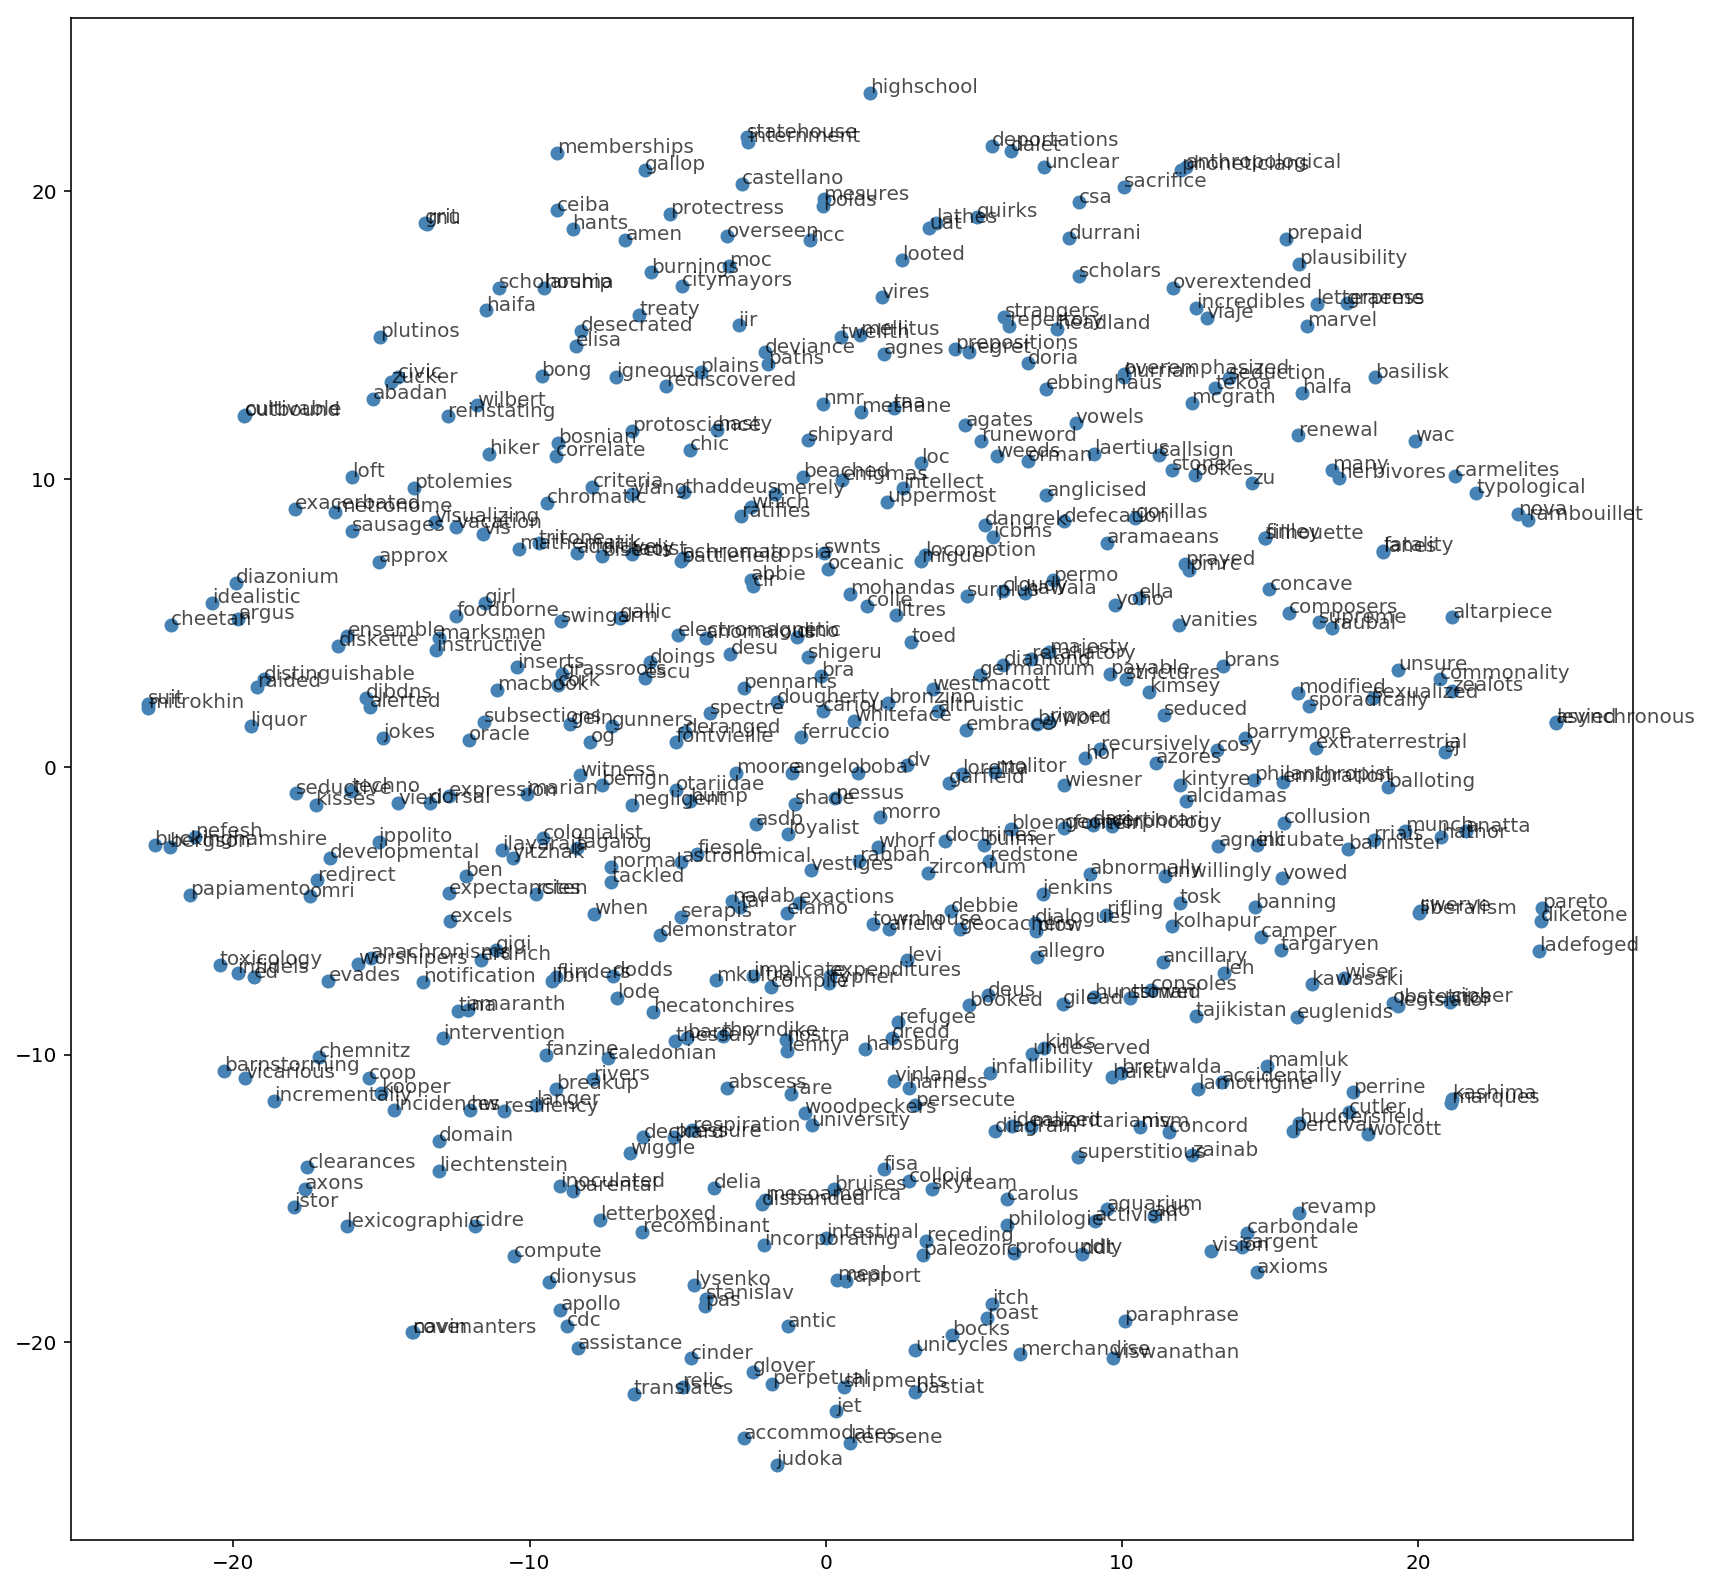

In [26]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# 7 Reference

[1] [深入浅出Word2Vec原理解析](https://mp.weixin.qq.com/s/zDneR1BU6xvt8cndEF4_Xw)

[2] [基于TensorFlow实现Skip-Gram模型](https://zhuanlan.zhihu.com/p/27296712)

[3] [用TensorFlow实现Word2Vec中的Skip-Gram模型](https://github.com/NELSONZHAO/zhihu/blob/master/skip_gram/Skip-Gram-English-Corpus.ipynb)

[4] [理解 Word2Vec 之 Skip-Gram 模型](https://zhuanlan.zhihu.com/p/27234078)